In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_csv('cleaned_city_Day.csv')
df.head(10)

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,AQI,AQI_Bucket,Month,Year
0,Ahmedabad,2015-01-01,58.37,107.96,0.92,18.22,17.15,14.89,0.920,27.64,133.36,149.0,Moderate,1,2015
1,Ahmedabad,2015-01-02,58.37,107.96,0.97,15.69,16.46,14.89,0.970,24.55,34.06,106.0,Moderate,1,2015
2,Ahmedabad,2015-01-03,58.37,107.96,17.40,19.30,29.70,14.89,17.400,29.07,30.70,303.0,Very Poor,1,2015
3,Ahmedabad,2015-01-04,58.37,107.96,1.70,18.48,17.97,14.89,1.700,18.59,36.08,106.0,Moderate,1,2015
4,Ahmedabad,2015-01-05,58.37,107.96,22.10,21.42,37.76,14.89,22.100,39.33,39.31,330.0,Very Poor,1,2015
5,Ahmedabad,2015-01-06,58.37,107.96,45.41,38.48,81.50,14.89,45.410,45.76,46.51,401.0,Severe,1,2015
6,Ahmedabad,2015-01-07,58.37,107.96,112.16,40.62,130.77,14.89,112.160,32.28,33.47,401.0,Severe,1,2015
7,Ahmedabad,2015-01-08,58.37,107.96,80.87,36.74,96.75,14.89,80.870,38.54,31.89,401.0,Severe,1,2015
8,Ahmedabad,2015-01-09,58.37,107.96,29.16,31.00,48.00,14.89,29.160,58.68,25.75,372.0,Very Poor,1,2015
9,Ahmedabad,2015-01-10,58.37,107.96,16.28,7.04,0.00,14.89,16.245,8.29,4.55,289.0,Poor,1,2015


In [3]:
pollutants = df.columns[2:11].values
pollutants

array(['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3'],
      dtype=object)

In [4]:
x = df.iloc[:, 2:11]
y = df.loc[:, 'AQI']

In [5]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3, random_state=42)

In [6]:
print(f"Actual Data size: {df.shape}")
print(f"Training Data size: {x_train.shape}")
print(f"Test Data size: {x_test.shape}")

Actual Data size: (27963, 15)
Training Data size: (19574, 9)
Test Data size: (8389, 9)


In [7]:
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()
x_train = sc_x.fit_transform(x_train)
x_test = sc_x.transform(x_test)
y_train = sc_y.fit_transform(np.array(y_train).reshape(-1,1))
y_test = sc_y.transform(np.array(y_test).reshape(-1,1))

In [8]:
y_train[:10]

array([[-0.59776401],
       [-0.24301839],
       [ 1.59586707],
       [ 1.93613328],
       [-0.60500371],
       [-0.55432577],
       [-0.55432577],
       [ 1.32799793],
       [ 2.42843332],
       [-0.80047579]])

In [9]:
from sklearn.ensemble import GradientBoostingRegressor
gb_reg = GradientBoostingRegressor()
gb_reg.fit(x_train,y_train)

GradientBoostingRegressor()

In [10]:
y_pred = gb_reg.predict(x_test)
y_pred

array([-0.62004746,  1.36795269, -0.3531923 , ..., -0.17200024,
       -0.46813611,  0.64154144])

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

MAE: 0.16061777321496343
MSE: 0.10903035913250705
RMSE: 0.3301974547638232
R2: 0.8776410626435392


In [12]:
y_test = sc_y.inverse_transform(y_test.reshape(-1,1))
y_pred = sc_y.inverse_transform(y_pred.reshape(-1,1))
y_pred[:5]

array([[ 75.92205066],
       [350.5188371 ],
       [112.78199135],
       [ 75.36170618],
       [ 86.0545186 ]])

In [13]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

MAE: 22.18567459462356
MSE: 2080.202044469476
RMSE: 45.609232009204845
R2: 0.8776410626435391


In [14]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

MAE: 22.18567459462356
MSE: 2080.202044469476
RMSE: 45.609232009204845
R2: 0.8776410626435391


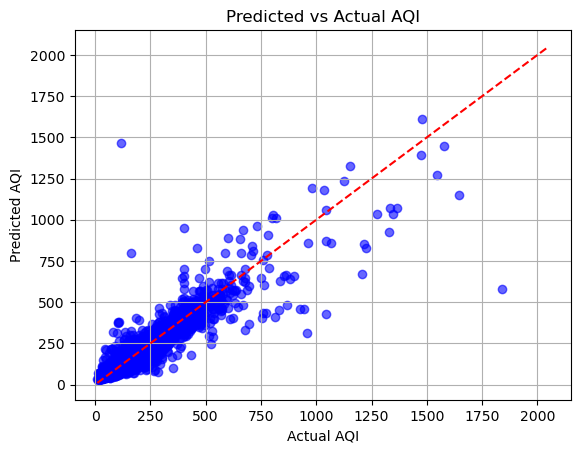

In [15]:
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # 45-degree reference line
plt.xlabel("Actual AQI")
plt.ylabel("Predicted AQI")
plt.title("Predicted vs Actual AQI")
plt.grid(True)
plt.show()


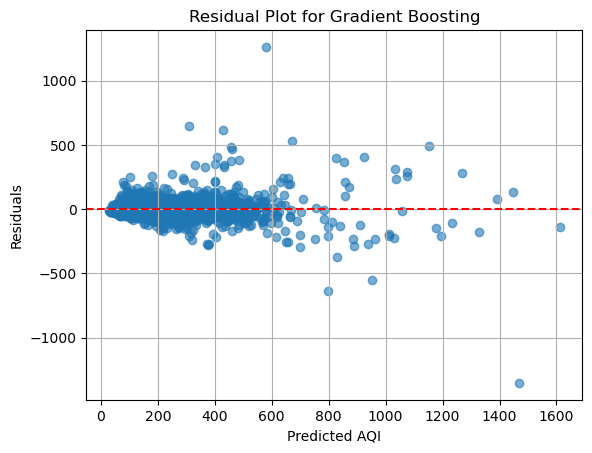

In [16]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Predicted AQI")
plt.ylabel("Residuals")
plt.title("Residual Plot for Gradient Boosting")
plt.grid(True)
plt.show()


In [17]:
df_GBoost = pd.DataFrame({'Actual':y_test[80:150].flatten(), 'Predicted':y_pred[80:150].flatten()})
df_GBoost.head(10)

,Actual,Predicted
0,40.0,50.733686
1,95.0,95.022591
2,110.0,83.618825
3,86.0,90.614654
4,108.0,132.407098
5,106.0,76.531439
6,102.0,86.512502
7,126.0,169.906636
8,57.0,73.486950
9,57.0,64.613076


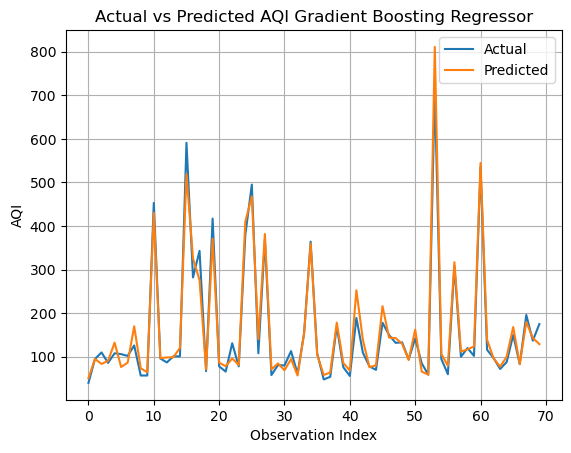

In [18]:
df_GBoost.plot(kind='line')
plt.title('Actual vs Predicted AQI Gradient Boosting Regressor')
plt.xlabel('Observation Index')
plt.ylabel('AQI')
plt.grid()
plt.savefig('GB_actualVSpredicted.png')
plt.show()

In [19]:
print(f"Train Score: {gb_reg.score(x_train, y_train)}")
print(f"Test Score: {r2_score(y_test, y_pred)}")

Train Score: 0.9247686580317696
Test Score: 0.8776410626435391


In [47]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3, random_state=42)

In [48]:
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()
x_train = sc_x.fit_transform(x_train)
x_test = sc_x.transform(x_test)
y_train = sc_y.fit_transform(np.array(y_train).reshape(-1,1))
y_test = sc_y.transform(np.array(y_test).reshape(-1,1))

In [49]:
best_model = random_search.best_estimator_
y_pred = best_model.predict(x_test)

# Then evaluate
from sklearn.metrics import r2_score
print("R2 Score on test data:", r2_score(y_test, y_pred))

R2 Score on test data: 0.8829621794387486


In [50]:
random_search.best_params_

{'subsample': 0.8, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.05}

In [51]:
gb_reg_tuned = GradientBoostingRegressor(n_estimators=100, learning_rate=0.05, subsample=0.8)
gb_reg_tuned.fit(x_train,y_train)
y_pred_tuned = gb_reg_tuned.predict(x_test)

In [52]:
mae = mean_absolute_error(y_test, y_pred_tuned)
mse = mean_squared_error(y_test, y_pred_tuned)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_tuned)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

MAE: 0.16608870311339033
MSE: 0.11238636961318363
RMSE: 0.335240763650818
R2: 0.8738747916760771


In [53]:
y_test = sc_y.inverse_transform(y_test.reshape(-1,1))
y_pred_tuned = sc_y.inverse_transform(y_pred_tuned.reshape(-1,1))

In [54]:
mae = mean_absolute_error(y_test, y_pred_tuned)
mse = mean_squared_error(y_test, y_pred_tuned)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_tuned)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

MAE: 22.941358526899545
MSE: 2144.2317323354036
RMSE: 46.30584987164585
R2: 0.8738747916760771
